# The Lieb-Robinson lightcone

In this project we propose the way out of this difficulty. We propose to consider the Lieb-Robinson lightcone as a real-time alterantive to the equilibrium Gibbs distribution.  The Lieb-Robinson lightcone always exists in the condensed matter.  


## Example: Interaction quench for qubit (atom) in the waveguide

Let us illustrate it on a specific example. Suppose we have a qubit (two-level atom) with a transition frequency $E_{at}$. We suppose there is a laser driving $f(t) = 0.1 \cos(t)$ acting on the qubit. As a result, it fluoresces into the waveguide. The latter is represented as a bosonic chain with constant hoppings $h$ and on-site energies $\varepsilon$. The total Hamiltonian is:

$$
H\left(t\right) = E_{at}  \sigma_{z} + \sigma_{x} \cdot f(t) + h \sigma_{+} a_{0} + h a^{\dagger}_{0} \sigma_{-} + \sum\limits_{i=0}^{\infty} (\varepsilon a^{\dagger}_{i} a_{i} + h a^{\dagger}_{i+1} a_{i} + h a^{\dagger}_{i} a_{i+1})  
$$


Let us program this Hamiltonian:


In [1]:
# in python, we define this model in the following way:

# 1. We define the two-state Hilbert space of the qubit (atom)
# as one bosonic mode truncated at one excitation
import secondquant as sq
hs_atom = sq.fock_space(num_modes = 1, max_total_occupation = 1, statistics = 'Bose')

# 2. We define the Fock space of the waveguide (bosonic chain).
# We truncate it at
m = 9 # modes  and at a total occupation of
n = 7 #  quanta
fs_chain = sq.fock_space(num_modes = m, max_total_occupation = n, statistics = 'Bose') 

# 3. The joint Hilbert space is given by a tensor product:
hs_joint = sq.fock_space_kron(hs_atom, fs_chain)

# 4. The creation and annihilation operators are provided as
b_hat = hs_joint.annihilate
b_hat_dag = hs_joint.create

Here <code> b_hat[0] </code> and <code> b_hat_dag[0] </code> correspond to $\sigma_{-}$ and $\sigma_{+}$ of the qubit degree of freedom:

In [2]:
sigma_m = b_hat[0]
sigma_p = b_hat_dag[0]
sigma_x = hs_joint.sigmax(0)

Also, <code> b_hat[i + 1] </code> and <code> b_hat_dag[i + 1] </code> correspond to $a_{i}$ and $a^{\dagger}_{i}$ of the chain: 

In [3]:
a_hat = b_hat[1:]
a_hat_dag = b_hat_dag[1:]

Therefore, the Hamiltonian becomes:

In [4]:
Eat = 1.0
h = 0.05
e = 1.0
def f(t):
    return(0.1*np.cos(t))

Hconst = Eat * sigma_p @ sigma_m + sigma_p @ a_hat[0] + sigma_m @ a_hat_dag[0] \
    + e * sum([a_hat_dag[i] @ a_hat[i] for i in range(m)]) \
    + h * sum([a_hat_dag[i + 1] @ a_hat[i] + a_hat_dag[i] @ a_hat[i + 1] for i in range(m-1)])

def H(t):
    return Hconst + f(t) * sigma_x

Let us consider the interaction quench. That is, initially the qubit and the waveguide are in their ground states. The initial wavefunction <code> psi_ini </code> has only one non-zero component <code> psi_ini[0] </code> which corresponds to the ground state:

In [5]:
import numpy as np
K = hs_joint.dimension
psi_ini = np.zeros(K, dtype = complex)
psi_ini[0] = 1 

Then we suddenly turn on the interaction due to $H(t)$. As the result, the disturbance starts to propagate gradually along the waveguide. We can visualize it by solving the nonstationary Schrodinger equation 

$$
    i\frac{\partial \Psi\left(t\right)}{\partial t} = \widehat{H}\left(t\right)\Psi\left(t\right)
$$

and computing the occupations <code> ni[j, i] </code> of the  waveguide sites, <code> ni[j,i] </code> = $ \left\langle\Psi\left(t_i\right)|a_j^{\dagger} a_j|\Psi\left(t_i\right)\right\rangle$:

In [6]:
import tools
tmax = 100
dt = 0.01
t = np.arange(start = 0, stop = tmax, step = dt)
nt = t.size
ni = np.zeros((m, nt))

# The midpoint Hamiltonian for time t = ti * dt
def Hi(ti):
    return H(ti * dt + dt/2)

# Solve the Schrodinger equation via implicit midpoint method on time grid
for i, psi in tools.evolution(start_index = 0, end_index = nt, H = Hi, dt = dt, initial_state = psi_ini):
    for j in range(m):
        ni[j, i] = (np.conj(psi) @ a_hat_dag[j]@a_hat[j] @ psi).real



Let us visualize the grid <code> ni[j, i] </code>:

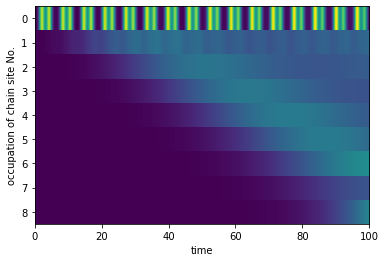

In [7]:
import matplotlib.pyplot as plt
 
plt.imshow(ni, cmap='viridis',  aspect='auto', interpolation = 'none')
plt.xlabel('time')
plt.ylabel('occupation of chain site No.')
plt.xticks([0, 2000, 4000, 6000, 8000, 10000], labels=["0", "20", "40", "60", "80", "100"])
plt.show()


We observe the lightcone-like spread of disturbance.  